# Lista 2 de Ejercicios

### Objetivo:
Este ejercicio pretende aumentar la destreza del estudiante para dibujar gráficos descriptivos comunes, testear múltiples modelos de clasificación de forma rápida y poner en práctica transformadores habituales de la librería __sklearn__.

### Tarea del estudiante:

Mismas instrucciones que en el anterior Notebook.

### Evaluación: 
Esta tarea tiene una puntuación de 14 puntos. 
La suma de todos los puntos obtenidas de todos los notebooks se ponderará sobre 10 puntos para computar la nota final del estudiante.

## Parte 0: Inicialización

En esta parte, simplemente cargamos las librerías que vamos a utilizar y establecemos una semilla para controlar la reproducibilidad del ejercicio.

In [1]:
""" Librerías """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

""" Semilla """

seed = 63

## Parte 1: Lectura y transformación de datos (0.5 puntos)

En esta parte, principalmente, cargaremos los datos de un repositorio git y realizaremos una breve limpieza de los datos para conseguir un dataframe listo.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/eduardofc/data/main/kddcup99.csv')

print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
df.head()

Número de filas: 561, Número de columnas:10


,duration,protocol_type,service,flag,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',0,0,0.0,0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',0,0,0.0,1,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',0,1,0.0,1,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',0,0,1.0,1,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',0,0,0.0,1,1.0,b'normal.'


Para entender la evolución de las transformaciones que vamos a ir haciendo, practicaremos algunos de los plots más utilizados.

En la siguiente celda se pide, mostrar un _countplot_ (_barplot_ de seaborn) para todas las variables del _dataframe_ (df).

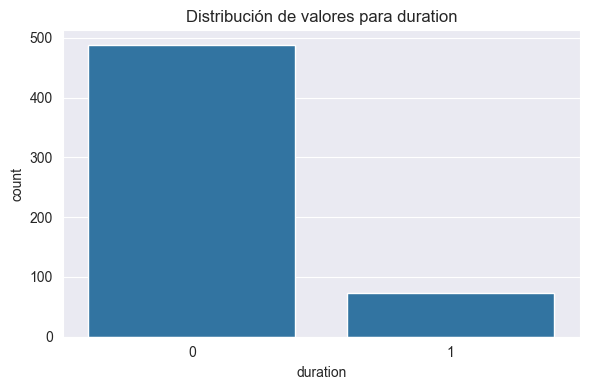

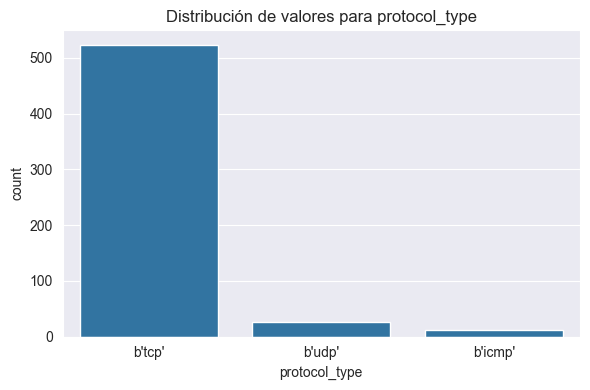

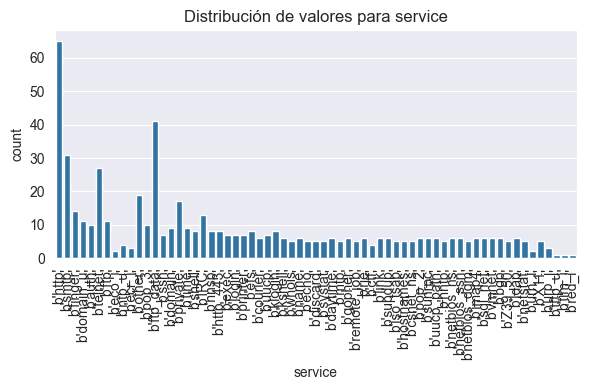

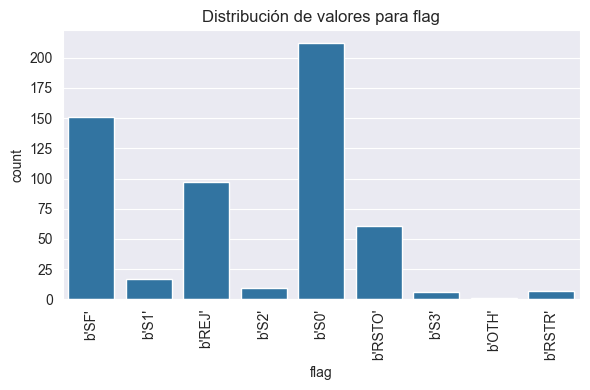

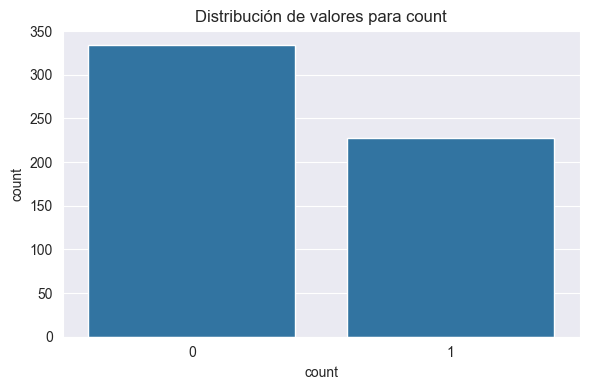

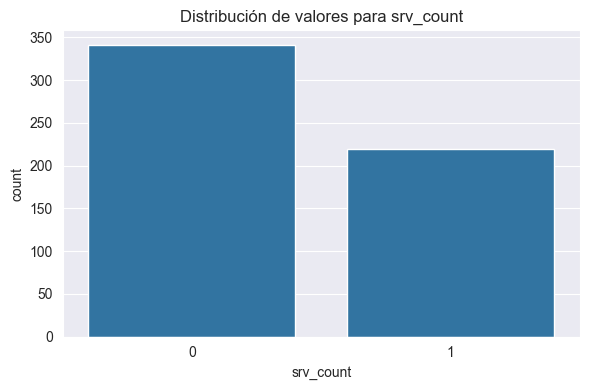

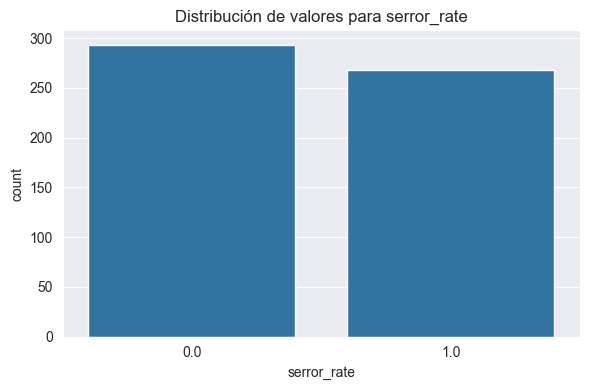

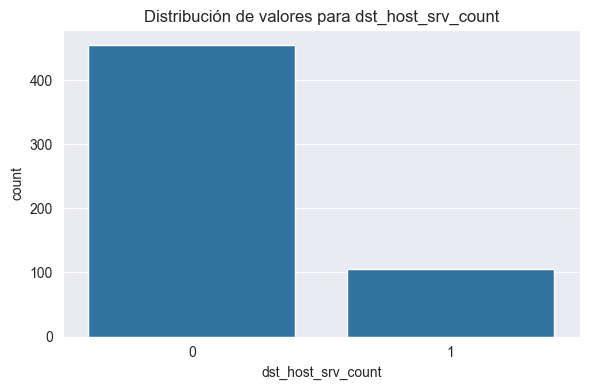

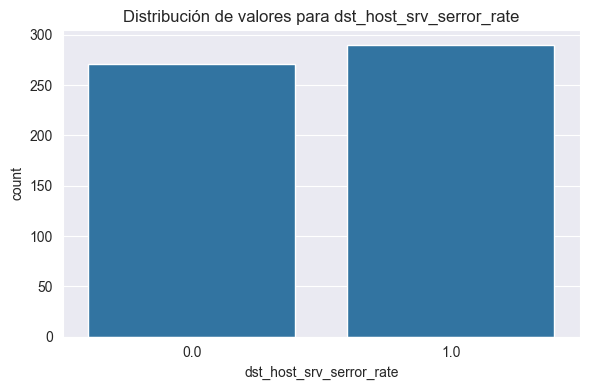

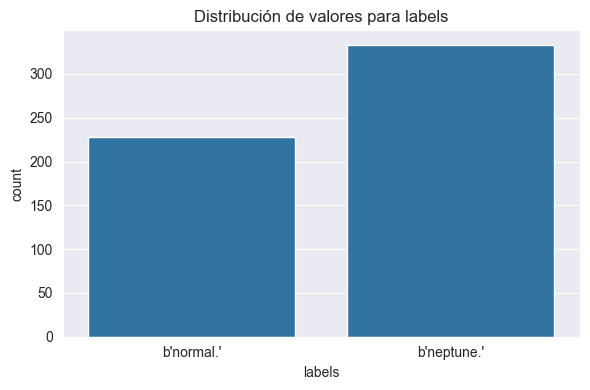

In [3]:
### Codigo del estudiante

for col in df.columns:
    plt.figure(figsize = (6, 4))
    sns.countplot(x = col, data = df)
    plt.title(f'Distribución de valores para {col}')
    if df[col].nunique() > 5:
        plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

Trabajaremos las variables categóricas con __pandas__. Trataremos de reducir el número de variables categóricas cuando existen demasiadas casuísiticas o cuando existen muy pocos registros en una categoría.

En esta celda se pide,
- para la variables _service_, localizar las 6 categorías más frecuentes y transformar estas columnas para que ponga _resto_ a todos aquellos registros de estas variables que no están entre las frecuentes, dejando así 7 catgorías en total.
- para la variables _flag_, localizar las 4 categorías más frecuentes y transformar estas columnas para que ponga _resto_ a todos aquellos registros de estas variables que no están entre las frecuentes, dejando así 5 catgorías en total.

Finalmente, eliminad duplicados.

In [4]:
### Codigo del estudiante

top_6 = df['service'].value_counts().keys().to_list()[:6]
new_data = [data if data in top_6 else 'resto' for data in df['service'].to_list()]
df['service'] = new_data

top_4 = df['flag'].value_counts().keys().to_list()[:4]
new_data = [data if data in top_4 else 'resto' for data in df['flag'].to_list()]
df['flag'] = new_data

df = df.drop_duplicates()

df.groupby('labels').size()

labels
b'neptune.'     61
b'normal.'     149
dtype: int64

Celda de control:

In [5]:
assert df.shape == (210, 10)
assert df.groupby('service').size()["resto"] == 44
assert df.groupby('flag').size()['resto'] == 25

## Parte 2: Modelos

En esta parte, testearemos distintos modelos con trasnformaciones adicionales a las vistas en la Lista 1 de Ejercicios.

Nota: Recordar utilizar la semilla cuando aplique.

In [6]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('PER', Perceptron(random_state=seed)))
models.append(('RFC', RandomForestClassifier(random_state=seed)))

def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

def pca_results(results, names, components):
    df2 = pd.DataFrame(zip(results, names, components), columns=['results', 'names', 'components'])

    sns.catplot(data=df2, kind="bar", x="names", y="results", hue="components", height=5, aspect=15/5)
    plt.ylim((0.6, 1.))
    plt.show()

cat_cols = ['protocol_type', 'service', 'flag']
num_cols = ['duration', 'count', 'srv_count', 'serror_rate',
            'dst_host_srv_count', 'dst_host_srv_serror_rate']
target = 'labels'

### Modelos 1 (2 puntos)

Realizar un estudio de machine learning con las siguientes características:
* probar los 4 algoritmos en bucle
* usar la técnica de validación cruzada StratifiedKFold (5 _folds_) de forma aleatoria.
* entrenar solo con variables numéricas

En cada iteración del bucle, almacenar el resultado de cada validación cruzada en una variable _results_ y los nombres de cada algoritmo en una variable _names_.

Finalmente, usaremos la función *boxplots_algorithms* para dibujar los resultados.

Nota: La función _cross_val_score_ nos vale para estudiar el comportamiento de los modelos con una validación cruzada.

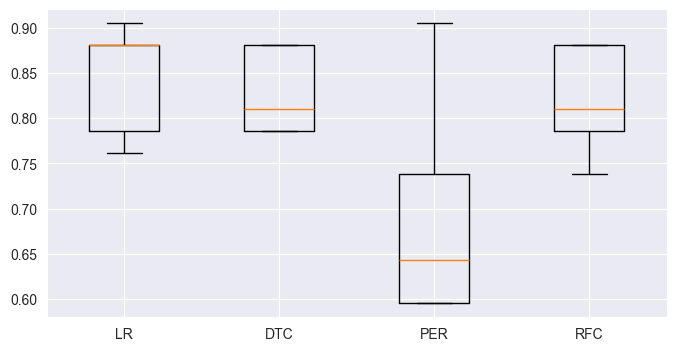

In [7]:
results = []
names = []

### Codigo del estudiante

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

X = df[num_cols]
y = df[target]

for name, model in models:
    scores = cross_val_score(model, X, y, cv = cross_validation)
    results.append(scores)
    names.append(name)
    
boxplots_algorithms(results, names)

Celda de control:

In [8]:
assert np.round(results[0].mean(),3) == 0.843
assert np.round(results[1].mean(),3) == 0.829
assert np.round(results[2].mean(),3) == 0.695
assert np.round(results[3].mean(),3) == 0.819

### Modelos 2 (2 puntos)

Realizar un estudio de machine learning con las siguientes características:
* probar los 4 algoritmos en bucle
* usar la técnica de validación cruzada KFolds (5 _folds_) aleatoria
* usar un pipeline que encadene
    * OneHotEncoder simple con las variables categóricas
    * algortimo
    * _remainder_ tipo _drop_
* Filtrar en X todas las variables**

\*\*Nota: Aunque la opción de _drop_ en el ColumnTransformer haga que solo se entrene con las variables que son usadas en este transformador, vamos a filtrar *X = df[cat_cols+num_cols]* para que podamos explorar la mejora en el siguiente apartado.

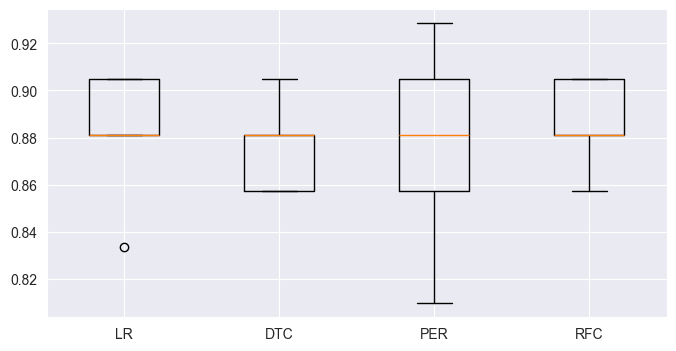

In [9]:
results = []
names = []

### Codigo del estudiante

X = df[cat_cols + num_cols]
y = df[target]

cross_validation = KFold(n_splits = 5, shuffle = True, random_state = seed)

ctransf = ColumnTransformer(
    transformers = [("cat", OneHotEncoder(handle_unknown = "ignore"), cat_cols)],
    remainder="drop"
)

for name, model in models:
    pipeline = Pipeline([
        ("encoder", ctransf),
        ("model", model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv = cross_validation)
    results.append(scores)
    names.append(name)

boxplots_algorithms(results, names)

Celda de control:

In [10]:
assert np.round(results[0].mean(),3) == 0.881
assert np.round(results[1].mean(),3) == 0.876
assert np.round(results[2].mean(),3) == 0.876
assert np.round(results[3].mean(),3) == 0.886

### Modelos 3 (1 punto)

Realizar un mismo estudio que en Modelos 2, pero esta vez cambiando, la opción _remainder_ a tipo _passthrough_.

Nota, se recomienda que estudiar el significado de este argumento y reflexionar sobre los resultados.

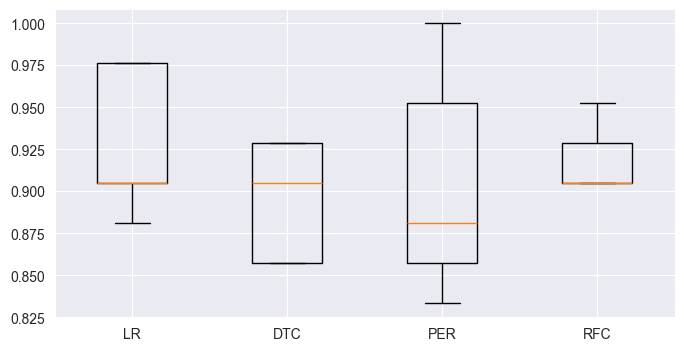

In [11]:
results = []
names = []

### Codigo del estudiante

X = df[cat_cols + num_cols]
y = df[target]

cross_validation = KFold(n_splits = 5, shuffle = True, random_state = seed)

ctransf = ColumnTransformer(
    transformers = [("cat", OneHotEncoder(handle_unknown = "ignore"), cat_cols)],
    remainder = "passthrough"
)

for name, model in models:
    pipeline = Pipeline([
        ("encoder", ctransf),
        ("model", model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv = cross_validation)
    results.append(scores)
    names.append(name)

boxplots_algorithms(results, names)

Celda de control:

In [12]:
assert np.round(results[0].mean(),3) == 0.929
assert np.round(results[1].mean(),3) == 0.895
assert np.round(results[2].mean(),3) == 0.905
assert np.round(results[3].mean(),3) == 0.919

### Modelos 4 (3 puntos)

Vamos a tratar de explorar si mejorarmos el modelo mediante una transformación de PCA. Usaremos las mismas (X,y). En esta celda se pide, realizar un estudio de machine learning en bucle con las siguientes características:
* probad 4 algoritmos en bucle
* probad 4 PCA dentro del pipeline y en bucle (dentro del bucle anterior) con _n\_components_=2,3,4,5, para cada algoritmo
* usad la técnica de validación Folds (5 folds) aleatorio
* usad un pipeline que encadene
     * One-hot-encoder con las variables categoricas, especificando eliminar la primera columna si es binaria
     * PCA
     * algortimo
* mostrad la matriz de confusión en cada caso

En cada iteración del bucle, almacenar la media de cada resultado de cada validación cruzada en una variable _results_ y los nombres de cada algoritmo en una variable _names_. Además, se pide guardar las componentes en la lista _components_).

Finalmente, usaremos la función *pca_results* para dibujar los resultados.

- Nota 1, ojo que esta vez se pide guardar la media de los resultados, no todos los resultados.

- Nota 2, revisad que primero sea un bucle que itere los modelos y, dentro de este bucle, otro bucle que itere las componentes.

- Nota 3, PCA tiene _random_state_.

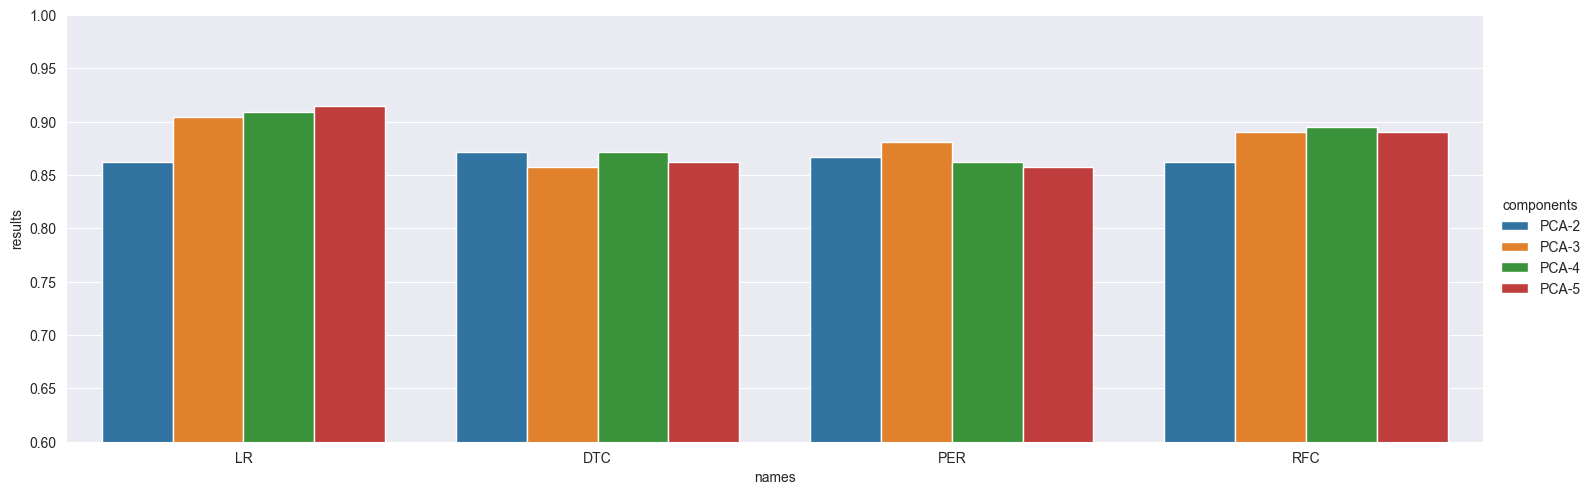

In [13]:
results = []
names = []
components = []

### Codigo del estudiante

X = df[cat_cols + num_cols]
y = df[target]

cross_validation = KFold(n_splits = 5, shuffle = True, random_state = seed)

for name, model in models:
    for n_components in [2, 3, 4, 5]:
        pipeline = Pipeline([
            ("encoder", ColumnTransformer(
                transformers=[("cat", OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore'), cat_cols)],
                remainder="passthrough"
            )),
            ("pca", PCA(n_components = n_components, random_state = seed)),
            ("model", model)
        ])
        
        y_pred = cross_val_predict(pipeline, X, y, cv = cross_validation)
        
        score = cross_val_score(pipeline, X, y, cv = cross_validation).mean()
        results.append(score)
        names.append(name)
        components.append(f"PCA-{n_components}")

pca_results(results, names, components)

Celda de control:

In [14]:
assert [np.round(results[x], 3) for x in [1,7,10]] == [0.905, 0.862, 0.862]

### Modelos 5 (2.5 puntos)

De ahora en adelante, trabajaremos solo con el algoritmo de RandomForestClassifier (sin PCA) y entrenaremos con todas las variables, teniendo en cuenta que las variables categóricas deben transformarse previamente con un OHE.

En esta celda se pide, separar primero el _dataset_ en _train_ (80%) y _test_ (20%). Tras ello, solo con el _train_, se pide realizar un ajuste de machine learning con las siguientes características:

* Sin validación cruzada
* Usar un pipeline que encadene
    * One-hot-encoder con las variables categóricas, especificando eliminar la primera columna si es binaria
    * algortimo
* Realizar la predicción de _train_ y _test_ por separado para poder mostrar ambas matrices de confusión.

En esta parte, conviene reflexionar si se está haciendo _overfitting_. Al entrenar con _train_ y evaluar con _test_ después, si las métricas difieren demasiado a juicio del _data scientist_, podríamos considerar que pueda existir sobreajuste. Teóricamente la validación cruzada ayuda a minimizar este problema; sin embargo, no siempre es así (sobre todo con algoritmos de tipo árbol) y conviene chequear que esto no ocurra. En esta celda, se va a pedir almacenar el _accuracy_ del modelo para los conjuntos _train_ y _test_, y se van a almacenar en las variables _acc_train_ y _acc_test_.

Otra cosa a tener en cuenta es la matriz de confusión. Ésta ofrece siempre el resultado de aplicar el modelo en la clasificación de una forma más legible, lo que ayuda a interpretar mejor el comportamiento de este modelo. En esta celda, almacenaremos ambas matrices de confusión en las variables _cm_train_ y _cm_test_.

Nota, no olvidar la semilla.

In [15]:
acc_train = 0
acc_test = 0

cm_train = np.array([[0, 0],[0, 0]])
cm_test = np.array([[0, 0],[0, 0]])

### Codigo del estudiante

X = df[cat_cols + num_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

pipeline = Pipeline([
    ("encoder", ColumnTransformer(
        transformers=[("cat", OneHotEncoder(drop = "if_binary", handle_unknown = "ignore"), cat_cols)],
        remainder = "passthrough"
    )),
    ("model", RandomForestClassifier(random_state = seed))
])


pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(cm_train)
print(acc_train)

print(cm_test)
print(acc_test)

[[ 44   2]
 [  4 118]]
0.9642857142857143
[[10  5]
 [ 0 27]]
0.8809523809523809


Celda de control:

In [16]:
assert np.round(acc_train, 4) == 0.9643
assert np.round(acc_test, 4) == 0.8810
assert (cm_train[0][0], cm_train[0][1], cm_train[1][0], cm_train[1][1]) == (44, 2, 4, 118)
assert (cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]) == (10, 5, 0, 27)

### Modelos 6 (3 puntos)

En el modelo previo, ya hemos encontrado un ajuste razonable. Ahora toca explorar si existe alguna parametrización que ayude a mejorar esta métrica.

En esta celda, vamos a separar primero el dataset en train y test. En concreto, separaremos el 20% del dataset en el test-set con el que validaremos la calidad real del modelo. Sin embargo, aquí añadiremos el argumento *stratified* dentro del `train_test_split` para asegurarnos de que hace una correcta partición entre las variables *y*.

Tras ello, solo con el _train_, se pide realizar un ajuste de machine learning con las siguientes características:
* usar el mismo algoritmo que en el apartado anterior
* usar la técnica de validación cruzada KFolds (5 folds)
* usar un pipeline que encadene:
     * OneHotEncoder si son tipo variables tipo _string_, especificando eliminar la primera columna si es binaria
     * algortimo
* realizar un tuneado del modelo con GridSearchCV (que almacenaremos en la variable *grid_model*) con los siguientes parámetros del algoritmo:
     * _n\_estimators_, 10, 20 y 30,
     * *max_features*, auto, sqrt y log2,
     * *max_depth*, 10, 20, 50, 70 y 100
     * _criterion_, gini y entropy.
    
Con el mejor de los modelos tuneados, realizad la predicción de _train_ y _test_ para mostrar ambas matrices de confusión y accuracies como en la celda anterior.

In [17]:
acc_train = 0
acc_test = 0

cm_train = np.array([[0, 0],[0, 0]])
cm_test = np.array([[0, 0],[0, 0]])

### Codigo del estudiante

X = df[cat_cols + num_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

pipeline = Pipeline([
    ("encoder", ColumnTransformer(
        transformers=[("cat", OneHotEncoder(drop = "if_binary", handle_unknown = "ignore"), cat_cols)],
        remainder="passthrough"
    )),
    ("model", RandomForestClassifier(random_state = seed))
])

param_grid = {
    "model__n_estimators": [10, 20, 30],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__max_depth": [10, 20, 50, 70, 100],
    "model__criterion": ["gini", "entropy"]
}

cross_validation = KFold(n_splits = 5, shuffle = True, random_state = seed)

grid_model = GridSearchCV(pipeline, param_grid, cv = cross_validation)
grid_model.fit(X_train, y_train)

y_train_pred = grid_model.predict(X_train)
y_test_pred = grid_model.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print(cm_train)
print(acc_train)

print(cm_test)
print(acc_test)

print(f'Best score: {grid_model.best_score_:.4f}')
grid_model.best_estimator_

[[ 47   2]
 [  2 117]]
0.9761904761904762
[[ 9  3]
 [ 2 28]]
0.8809523809523809
Best score: 0.9287


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['protocol_type', 'service',
                                                   'flag'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=20,
                                        random_state=63))])

Celda de control:

In [18]:
assert grid_model.cv.random_state == seed
assert np.round(acc_train, 4) == 0.9762
assert np.round(acc_test, 4) == 0.8810
assert (cm_train[0][0], cm_train[0][1], cm_train[1][0], cm_train[1][1]) == (47, 2, 2, 117)
assert (cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]) == (9, 3, 2, 28)
assert len(grid_model.param_grid) == 4
assert len(grid_model.estimator.named_steps) == 2